In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import time
import scipy.stats
import pandas as pd
import random

## Create Electronic Model Class

In [2]:
# Tolerances of electronic components
# Used to initialize the class

Vout = np.array([3.2, 3.3, 3.4])
LS_Ron = np.array([6.3, 8.3, 11])*1e-3
Iout = np.array([2.64, 3.03, 3.45])
Vin = np.array([13.3, 13.35, 13.37])
Fsw = np.array([430, 455, 489])*1e3
Vbody_diode = np.array([0.65, 0.8, 1.2])
L = np.array([5.4, 4.5, 3.6])*1e-6
DCR = np.array([12.61, 19, 27.23])*1e-3
P_IC = np.array([83.93, 88.81, 93.69])*1e-3

In [3]:
# Initialize Class
from PSU_class import PSU

model = PSU(Vout, LS_Ron, Iout, Vin, Fsw, Vbody_diode, L, DCR, P_IC)
model.P_in()

array([ 9.28592306, 10.85749529, 12.66975792])

## Simulate from Class

In [4]:
# Number of simulations
n_simulation = 20000

In [5]:
# Simulate output with parameters with Uniform Distribution
from helper_functions import simulation
random.seed(123456789)

simulation = simulation(n_simulation, model, PSU, "Gauss")

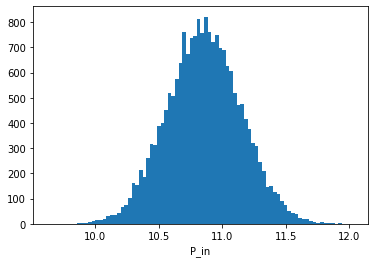

In [6]:
# Plot historgram
plt.hist(simulation, bins = 'auto')
plt.xlabel('P_in')
plt.show()

## Model Selection Methods

### Chi-Square

In [7]:
from helper_functions import compute_chi_square

results = compute_chi_square(simulation)

Distribution: weibull_min || Parameters: (535558243.74778223, -267297229.44106054, 267297240.3829161)
Distribution: norm || Parameters: (10.856259656824205, 0.29196822159622116)
Distribution: weibull_max || Parameters: (4.470640281019465, 12.036476365486973, 1.2922171674051224)
Distribution: beta || Parameters: (345.38517347399545, 411.7619384899366, 3.4934919387580834, 16.140525578260675)
Distribution: invgauss || Parameters: (0.023598770251486073, 8.847910431180633, 85.07085944759757)
Distribution: uniform || Parameters: (9.630874539601498, 2.3965155216442877)
Distribution: gamma || Parameters: (24535.77836922357, -34.8774172836174, 0.0018639586543390638)
Distribution: expon || Parameters: (9.630874539601498, 1.2253851172227073)
Distribution: lognorm || Parameters: (0.012149947523018092, -13.152122398001904, 24.006654089099236)
Distribution: pearson3 || Parameters: (0.01286539406037773, 10.856257563772813, 0.29196627225285543)
Distribution: triang || Parameters: (0.5161791279484609, 

In [8]:
results

,Distribution,Log_likelihood,Chi_square,Parameters
1,norm,-3756.564408,1.0,"(10.856259656824205, 0.29196822159622116)"
3,beta,-3756.264641,1.0,"(345.38517347399545, 411.7619384899366, 3.4934..."
6,gamma,-3756.291093,1.0,"(24535.77836922357, -34.8774172836174, 0.00186..."
9,pearson3,-3756.291087,1.0,"(0.01286539406037773, 10.856257563772813, 0.29..."
8,lognorm,-3757.240934,3.0,"(0.012149947523018092, -13.152122398001904, 24..."
2,weibull_max,-3867.225868,65.0,"(4.470640281019465, 12.036476365486973, 1.2922..."
4,invgauss,-4104.094446,231.0,"(0.023598770251486073, 8.847910431180633, 85.0..."
10,triang,-8369.215284,7107.0,"(0.5161791279484609, 9.630681006381643, 2.3968..."
0,weibull_min,-9531.021811,8574.0,"(535558243.74778223, -267297229.44106054, 2672..."
5,uniform,-17480.316328,21682.0,"(9.630874539601498, 2.3965155216442877)"


In [9]:
results.iloc[4]['Parameters']

(0.012149947523018092, -13.152122398001904, 24.006654089099236)

In [10]:
math.log(results.iloc[0]['Parameters'][0])

2.3847418405243683

**Model A:** Normal Distribution

**Model B:** Beta Distribution

### Non-Nested Likelihood Ratio Test

Compare **Model A** to **Model B** and choose the best fit. 

In [ ]:
from helper_functions import LRT

Q, qQi = LRT(results.iloc[:2], 1000, n_simulation)
if Q < qQi: print('Select model A')

### Q-Q Plot

Compare **Model A** to **Model B** on a quantile-quantile plot. 

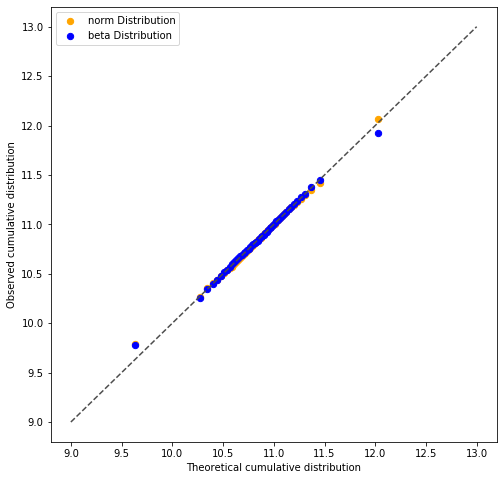

In [11]:
from helper_functions import qqplot

qqplot(simulation, results)

### Chosen Model Description

In [12]:
best_name = results.iloc[0]['Distribution']
best_params = results.iloc[0]['Parameters']

best_dist = getattr(scipy.stats, best_name)

## Plot Choosen Model Againts Data

In [13]:
import seaborn as sns

**Simulated Data Histogram**

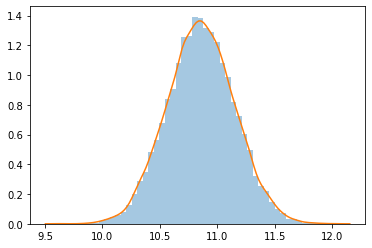

In [14]:
sns.distplot(a = simulation, kde = False, norm_hist=True)
sns.kdeplot(data = simulation, shade= False)

**Chosen Distribution Density Function**

In [15]:
simulation.sort()

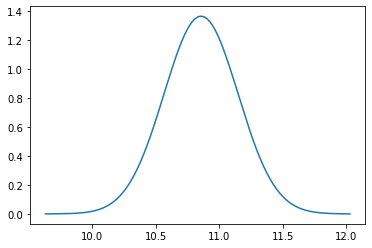

In [16]:
plt.plot(simulation, best_dist.pdf(simulation,*best_params))

**Chosen Distribution on top of Simulated Data Histogram**

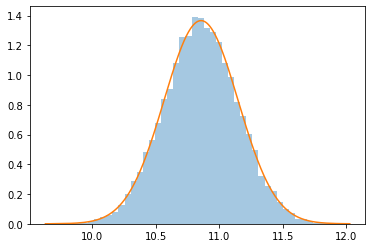

In [17]:
sns.distplot(a = simulation, kde = False, norm_hist=True)
plt.plot(simulation, best_dist.pdf(simulation, *best_params))

## Validation Methods

### Kolmogorov-Smirnoff 2 Sample Test

In [18]:
from scipy.stats import ks_2samp

In [19]:
data2 = best_dist.rvs(*best_params, size = 2000)
statistic, pvalue = ks_2samp(data1,data2)
print(f"The Statistic value is: {statistic} \nThe p_value is: {pvalue}")

The Statistic value is: 0.0325 
The p_value is: 0.24148215150724364


In [20]:
n1 = len(data1)
n2 = len(data2)
alpha = 0.05
c_alpha = 1.36 # https://sparky.rice.edu//astr360/kstest.pdf
critical_value = c_alpha * ((n1 + n2)/(n1*n2))**0.5 
critical_value

0.04300697617828996

In [21]:
if statistic > critical_value:
    print('The two samples come from different distributions')
else:
    print('The two samples come from same distributions')

The two samples come from same distributions


## Work Within Limits

### Quantiles

In [22]:
quantiles = best_dist.ppf([0.0001, 0.5, 0.9999], *best_params)
quantiles

array([ 9.77042503, 10.85625966, 11.94209429])

### Cp

In [23]:
# This value depends on the best distribution
sigma = best_params[1]

In [24]:
limit_min = model.P_in()[0]
limit_MAX = model.P_in()[2] 
Cp = (limit_MAX - limit_min)/(6 * sigma)
Cp

1.9316228130975093